In [1]:
#!/usr/bin/env python

from shutil import copyfile
import subprocess
from subprocess import Popen, PIPE
from multiprocessing import Pool, freeze_support, cpu_count
import matplotlib.pyplot as plt
import itertools
import os
from glob import glob
import numpy as np
import argparse
import sys

from itertools import islice
import cv2
from copy import copy, deepcopy
from scipy.ndimage import rotate

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
import config
import math

%autoreload 2
import mosaic as m

from skimage.io import imread, imsave
from skimage.color import gray2rgb, rgb2gray
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import warp, SimilarityTransform, AffineTransform, ProjectiveTransform
from skimage import img_as_float, img_as_ubyte
%matplotlib inline

ERROR: Line magic function `%autoreload` not found.


In [2]:
sift = cv2.SIFT()
orb = cv2.ORB()
surf = cv2.SURF()
brisk = cv2.BRISK()

In [3]:
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels. If img already has alpha, 
        nothing will be done. 
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    # don't do anything if there is already an alpha channel
    #return img
    
    if img.shape[2] > 3:
        return img
    # make sure the image is 3 channels
    if img.ndim == 2:
        img = gray2rgb(img)
    if mask is None: 
        # create transparent mask 
        # 1 should be fully transparent
        mask = np.ones(img.shape[:2], np.uint8)*255
    return np.dstack((img, mask))

def find_corners(all_corners):
    

    # The overally output shape will be max - min
    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)

    # Ensure integer shape with np.ceil and dtype conversion
    output_shape = np.ceil(output_shape[::-1]).astype(int)

    # This in-plane offset is the only necessary transformation for the base image
    offset = SimilarityTransform(translation= -corner_min)
    return offset, output_shape




def getKeypointandDescriptors(img, detector):
    detector = cv2.SIFT()
    kps, des = detector.detectAndCompute(img, None)
    kp = np.asarray([k.pt for k in kps])
    return kp, des

def loadImage(img_path, detector):
    rgb = add_alpha(cv2.imread(img_path))
    img = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
    # Find key points in base image 
    k, d = getKeypointandDescriptors(img, detector)
    return rgb, k, d  


def make_chunks(it, size):
    return [it[x:x+size] for x in range(0, len(it), size)]



In [4]:
def filter_matches(matches, ratio = 0.75):
    filtered_matches = []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            filtered_matches.append(m[0])

    return filtered_matches



def match_from_to(fk, fd, tk, td, min_matches):
    FLANN_INDEX_KDTREE = 1  # bug: flann enums are missing
    flann_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    matcher = cv2.FlannBasedMatcher(flann_params, {})
    print("STARTING MATCH")
    # get matching keypoints between images (from to) or (previous, base) or (next, base)
    if 1:
        #matches = match_descriptors(fd, td, cross_check=True)
        matches = matcher.knnMatch(fd, td, k=2)
        
        matches_subset = filter_matches(matches)
        matches_subset = np.array([[match.trainIdx,match.queryIdx] for match in matches_subset])
    
        src = fk[matches_subset[:,1]]
        dst = tk[matches_subset[:,0]]
        #src = [fk[match.queryIdx] for match in matches_subset]
        # target image is base image
        #dst = [tk[match.trainIdx] for match in matches_subset]

        src = np.asarray(src)
        dst = np.asarray(dst)

        if src.shape[0] > min_matches:
            
            # TODO - select which transform to use based on sensor data?
            model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=8, 
                                           residual_threshold=1)
            bad_matches = src.shape[0]-inliers.shape[0]
            precision= 1-float(bad_matches)/float(src.shape[0])
            
            ransac_matches = matches_subset[inliers]
            return model_robust, ransac_matches,precision
   # except Exception, e:
   #     logging.error(e)
    return None, None, 0

def warp_img(img, transform, output_shape):
    try:
        warped = warp(img, transform, order=1, mode='constant',
                   output_shape=output_shape, clip=True, cval=0)
        return warped
    except Exception, e:
        logging.error("Error warping image %s img shape %s, output shape %s" %(e, img.shape, output_shape))
        return None

def copy_new_files(input_dir, output_dir, in_ftype, out_ftype, wsize, do_clear, limit):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
        

    if do_clear:
        
        to_clear_mosaics = sorted(glob(os.path.join(output_dir, '*RUN*MATCH*%s'%out_ftype)))
        if len(to_clear_mosaics):
                logging.warning("Clearing RUN files from output_dir: %s" %output_dir)
                for f in to_clear_mosaics:
                    os.remove(f)
    
        #to_clear = sorted(glob(os.path.join(output_dir, '*%s'%out_ftype)))
        #if len(to_clear):
        #    logging.warning("Clearing files from output_dir: %s" %output_dir)
        #    for f in to_clear:
        #        os.remove(f)
        
    logging.info("Using convert to transfer and scan input images")
    in_files = sorted(glob(os.path.join(input_dir, '*%s'%in_ftype)))
    if limit is not None:
        try:
            in_files = in_files[:limit]
        except:
            pass
    
    for iimg in sorted(in_files):
        oname = os.path.basename(iimg).split('.')[0] + '.%s' %out_ftype
       
        ofile = os.path.join(output_dir, oname)
        if not os.path.exists(ofile):
            cmd = ["convert", iimg, "-resize", "%dx%d" %(wsize[0], wsize[1]), ofile]
            subprocess.call(cmd)
            #logging.info("Calling %s" %' '.join(cmd))
        else:
            pass
            #logging.debug("The file %s already exists" %ofile)



In [140]:


class doMosaic():
    def __init__(self, inputpath, outpath, input_image_type, do_clear=False, limit=None, wsize=(3000,2000), addedge=False):
        self.detector = "SIFT" #cv2.SIFT(4000)
        self.outpath = outpath
        self.out_ftype = 'png'
        # Parameters for nearest-neighbor matching
        self.total_matched = 0
        self.chunk_size = 3
        self.addedge = addedge
        self.brute_searched = False
        copy_new_files(inputpath, outpath, input_image_type, self.out_ftype, wsize, do_clear, limit)
        self.total_to_match = len(sorted(glob(os.path.join(self.outpath, '*%s'%self.out_ftype))))

    def run_round(self, ROUND_NUM, last_num_imgs=1e6):
        img_paths = sorted(glob(os.path.join(self.outpath, '*%s'%self.out_ftype)))
        
        num_imgs = len(img_paths)
        self.total_matched = self.total_to_match - num_imgs
        print("TOTAL MATCHED", self.total_matched)
        # make sure that we have made some progress
        # TODO: if num_imgs doesn't shrink, need to add full search
        logging.info("Starting new round: %s num_imgs: %d last_num_imgs: %s" %(ROUND_NUM, num_imgs, last_num_imgs))
        if num_imgs >= last_num_imgs:
            self.chunk_size += 1
            logging.debug("Didn't find any matches last run, increasing search space to: %s" %self.chunk_size)
        logging.info("FOUND %s images to stitch in round %s with chunk size: %s" %(num_imgs, ROUND_NUM, self.chunk_size ))
        # time to bring out the big guns
        # try to search every other image
        # TODO: put a cap on the number of images so this doesnt blow up
        if self.chunk_size >= num_imgs:
            logger.info("Chunk size is larger than number of images - chunk size: %s num_imgs: %s" %(self.chunk_size, num_imgs))
            logger.info("brute_forced:%s, num_imgs: %s, last_num_imgs: %s" %(self.brute_searched, num_imgs, last_num_imgs))

            if self.brute_searched and (num_imgs >= last_num_imgs):
                logger.error("Brute forced true and did not find any matches last run, exiting")
                return
            else:
                logger.info("Entering brute force search")
                for base_index, bn in enumerate(img_paths):
                    logger.info("Searching bn:%s against all other images with base index of %d" %(os.path.basename(bn), base_index))
                    self.stitch_chunk(img_paths, base_index, 0, ROUND_NUM)
                    ROUND_NUM+=1
                    img_paths = sorted(glob(os.path.join(self.outpath, '*%s'%self.out_ftype)))
                    logger.info("Brute force search against %s found %s matches" %(os.path.basename(bn), num_imgs-len(img_paths)))
                    num_imgs = len(img_paths)
                self.brute_searched = True
            self.run_round(ROUND_NUM+1, num_imgs) 
        else:  
            # divide into chunks of 3 to match together
            chunks = make_chunks(img_paths, self.chunk_size)
            # make sure we actually found files
            
            if len(chunks) > 1:
                for CHUNK_NUM, chunk in enumerate(chunks):
                    base_index = len(chunk)/2
                    self.stitch_chunk(chunk, base_index, CHUNK_NUM, ROUND_NUM)
                self.run_round(ROUND_NUM+1, num_imgs)   
            elif len(chunks) == 1:
                logging.info("ONLY ONE CHUNK left")
                if len(chunks[0]) == 1:
                    logging.info("FINISHED!")
                else:
                    logging.info("Working on last match")
                    self.stitch_chunk(chunks[0], 0, 0, ROUND_NUM)
            else:
                logging.error("DID not find any files")

    def stitch_chunk(self, chunk, base_index, CHUNK_NUM, ROUND_NUM):
        # TODO - still off by one eggh
        min_precision = 0.7
        min_matches = 11
        logging.debug("WORKING ON CHUNK num: %s of %s ROUND NUM: %s" %(CHUNK_NUM,' '.join([os.path.basename(c) for c in chunk]),  ROUND_NUM))
        if len(chunk) > 1:
            if not (base_index < len(chunk)):
                logging.error("Was given incompatible base_index of %d with chunk size of %d" %(base_index, len(chunk)))
                base_index = len(chunk)-1
                
            # load the center or right image to use as base
            bn = chunk.pop(base_index)
            #brgb = m.add_alpha(cv2.imread(img_path))
            #gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          
            brgb, bk, bd = m.loadImage(bn, self.detector, self.addedge)
            
            if bk.shape[0] > 8:
                # Shape of base image, our registration target
                r, c = brgb.shape[:2]

                # Note that transformations take coordinates in (x, y) format,
                # not (row, column), in order to be consistent with most literature
                base_corners = np.array([[0, 0], #image (0,0) coordinate
                                    [0, r], # 
                                    [c, 0],
                                    [c, r]])

                corners = deepcopy(base_corners)
                models = []
                match_names = []
                iis = []
                for name in chunk:
                    rgb, k, d = m.loadImage(name, self.detector, self.addedge)

                    model_robust, ransac_matches, matches, inliers, precision = m.match_from_to(k, d, bk, bd, min_matches)
                    #model_robust, ransac_matches, precision = match_from_to(k, d, bk, bd, min_matches)

                    logging.info("match precision: %s  for base %s with %s" %(precision, os.path.basename(bn), 
                                                                            os.path.basename(name)))
                    
                    if precision > min_precision:
                        models.append(model_robust)
                        iis.append(rgb)
                        tcorners = model_robust(base_corners)
                        match_names.append(name)
                        corners = np.vstack((corners, tcorners))
                    else:
                        logging.info("Not able to match with Base:%s %d, Img: %s %d keypoints" %(os.path.basename(bn),
                                                                                                 bk.shape[0],
                                                                                                 os.path.basename(name), 
                                                                                                 k.shape[0]))
                
                if len(models):
                    
                    offset, output_shape = m.find_corners(corners)
                    lbrgb = img_as_float(brgb)
                    brgb_warped = m.warp_img(lbrgb, offset.inverse, output_shape)
                    
                    if brgb_warped is None:
                        logger.error("Unable to warp base img %s" %os.path.basename(bn))
                    else:
                        oname = os.path.join(self.outpath, 'RUN%03d_MATCH%03d.%s' %(ROUND_NUM, CHUNK_NUM, self.out_ftype))
                        tnames = []
                        ubrgb_warped = img_as_ubyte(brgb_warped)
                        omask = np.zeros(ubrgb_warped.shape[:2], dtype=np.uint)
                        omask += ubrgb_warped[:,:,3]
                        print("Original mask", np.max(ubrgb_warped), np.min(ubrgb_warped))
                        #nbrgb_warped = img_as_ubyte(brgb_warped)
                        #nbrgb_warped[nbrgb_warped==0] = 120
                        #ulbrgb = img_as_ubyte(brgb_warped)
                        for xxv, (model, i, n) in enumerate(zip(models, iis, match_names)):
                            ## Translate base into place
                            tname = '/tmp/timg_%02d.png' %xxv
                            logging.debug("writing tmp %s to match with bn %s as %s" %(os.path.basename(n), os.path.basename(bn), tname))
                            transform = (model + offset).inverse
                            rgb_warped = m.warp_img(i, transform, output_shape)
                            urgb_warped = img_as_ubyte(rgb_warped)
                            print("MAX", np.max(omask), np.max(urgb_warped))
                            omask[urgb_warped[:,:,3] > 0] = 255
                            if rgb_warped is None:
                                logger.error("Base warp: Unable to warp img %s" %os.path.basename(n))
                            else:
                                # successful warp
                                #plt.imsave(tname, rgb_warped)
                                cv2.imwrite(tname, urgb_warped)
                                
                                tnames.append(tname)
                            
                                
                        if not len(tnames):
                            logger.info("Not able to match %s images to %s" %(len(chunk), os.path.basename(n)))
                        else:
                            bname = '/tmp/bimg.png'
                            cv2.imwrite(bname, ubrgb_warped)
                            tnames.append(bname)
                            match_names.append(bn)
                            cmd = ['enblend']
                            cmd.extend(tnames)
                            toname = '/tmp/tbimg.png'
                            cmd.extend(['-o', toname])
                            logger.info("Calling subprocess command: %s" % ' '.join(cmd))
                            subprocess.call(cmd)
                            
                            #omask = img_as_ubyte(omask/float(len(tnames)))
                            #plt.figure()
                            #plt.gray()
                            #plt.imshow(omask)
                            oimg = cv2.imread(toname)
                            print("READING OUTPUT", oimg.shape)
                            oout = m.add_alpha(oimg, omask)
                            cv2.imwrite(oname, oout)
                            #cv2.imwrite(oname.replace('.png', 'a.png'), omask)
                            print("ADDED ALPHA", oname, oout.shape)
                            logger.info("Wrote %s matches to file: %s" %(len(tnames), os.path.basename(oname)))
                            
                            # TODO - check subprocess call
                            # should remove all in tnames
                            
                            mdir = os.path.join(os.path.split(match_names[0])[0], 'matched')
                            if not os.path.exists(mdir):
                                os.mkdir(mdir)
                            for f in match_names:
                                #os.remove(f)
                                na = os.path.split(f)[1]
                                oo = os.path.join(mdir, na)
                                cc = ['mv', f, oo]
                                subprocess.call(cc)


INFO:root:Using convert to transfer and scan input images
INFO:root:Starting new round: 1 num_imgs: 14 last_num_imgs: 1000000.0
INFO:root:FOUND 14 images to stitch in round 1 with chunk size: 3
DEBUG:root:WORKING ON CHUNK num: 0 of dsc04583.png dsc04584.png dsc04585.png ROUND NUM: 1


('TOTAL MATCHED', 0)
('LOADING', '/Users/jhansen/Desktop/test_out/dsc04584.png', (400, 600, 3))
('ADD ALPHA', (400, 600, 3))
('LOADING', '/Users/jhansen/Desktop/test_out/dsc04583.png', (400, 600, 3))

INFO:root:STARTING MATCH src: 111 dst 111
INFO:root:FOUND inliers 111
INFO:root:match precision: 1.0  for base dsc04584.png with dsc04583.png



('ADD ALPHA', (400, 600, 3))
('LOADING', '/Users/jhansen/Desktop/test_out/dsc04585.png', (400, 600, 3))

INFO:root:STARTING MATCH src: 57 dst 57
INFO:root:FOUND inliers 57
INFO:root:match precision: 1.0  for base dsc04584.png with dsc04585.png



('ADD ALPHA', (400, 600, 3))
('Original mask', 255, 0)

DEBUG:root:writing tmp dsc04583.png to match with bn dsc04584.png as /tmp/timg_00.png



('MAX', 255, 255)

DEBUG:root:writing tmp dsc04585.png to match with bn dsc04584.png as /tmp/timg_01.png



('MAX', 255, 255)

INFO:root:Calling subprocess command: enblend /tmp/timg_00.png /tmp/timg_01.png /tmp/bimg.png -o /tmp/tbimg.png



('READING OUTPUT', (956, 915, 3))
('ADD ALPHA', (956, 915, 3))
('ADDED ALPHA', '/Users/jhansen/Desktop/test_out/RUN001_MATCH000.png', (956, 915, 4))

INFO:root:Wrote 3 matches to file: RUN001_MATCH000.png
DEBUG:root:WORKING ON CHUNK num: 1 of dsc04586.png dsc04587.png dsc04588.png ROUND NUM: 1



('LOADING', '/Users/jhansen/Desktop/test_out/dsc04587.png', (400, 600, 3))
('ADD ALPHA', (400, 600, 3))
('LOADING', '/Users/jhansen/Desktop/test_out/dsc04586.png', (400, 600, 3))

INFO:root:STARTING MATCH src: 132 dst 132
INFO:root:FOUND inliers 132
INFO:root:match precision: 1.0  for base dsc04587.png with dsc04586.png



('ADD ALPHA', (400, 600, 3))
('LOADING', '/Users/jhansen/Desktop/test_out/dsc04588.png', (400, 600, 3))

INFO:root:STARTING MATCH src: 104 dst 104
INFO:root:FOUND inliers 104
INFO:root:match precision: 1.0  for base dsc04587.png with dsc04588.png



('ADD ALPHA', (400, 600, 3))
('Original mask', 255, 0)

DEBUG:root:writing tmp dsc04586.png to match with bn dsc04587.png as /tmp/timg_00.png



('MAX', 255, 255)

DEBUG:root:writing tmp dsc04588.png to match with bn dsc04587.png as /tmp/timg_01.png



('MAX', 255, 255)

INFO:root:Calling subprocess command: enblend /tmp/timg_00.png /tmp/timg_01.png /tmp/bimg.png -o /tmp/tbimg.png



('READING OUTPUT', (735, 682, 3))

INFO:root:Wrote 3 matches to file: RUN001_MATCH001.png
DEBUG:root:WORKING ON CHUNK num: 2 of dsc04589.png dsc04594.png dsc04595.png ROUND NUM: 1



('ADD ALPHA', (735, 682, 3))
('ADDED ALPHA', '/Users/jhansen/Desktop/test_out/RUN001_MATCH001.png', (735, 682, 4))
('LOADING', '/Users/jhansen/Desktop/test_out/dsc04594.png', (400, 600, 3))
('ADD ALPHA', (400, 600, 3))
('LOADING', '/Users/jhansen/Desktop/test_out/dsc04589.png', (400, 600, 3))

INFO:root:STARTING MATCH src: 47 dst 47
INFO:root:FOUND inliers 47
INFO:root:match precision: 1.0  for base dsc04594.png with dsc04589.png



('ADD ALPHA', (400, 600, 3))
('LOADING', '/Users/jhansen/Desktop/test_out/dsc04595.png', (400, 600, 3))

INFO:root:STARTING MATCH src: 121 dst 121
INFO:root:FOUND inliers 121
INFO:root:match precision: 1.0  for base dsc04594.png with dsc04595.png



('ADD ALPHA', (400, 600, 3))
('Original mask', 255, 0)

DEBUG:root:writing tmp dsc04589.png to match with bn dsc04594.png as /tmp/timg_00.png



('MAX', 255, 255)

DEBUG:root:writing tmp dsc04595.png to match with bn dsc04594.png as /tmp/timg_01.png



('MAX', 255, 255)

INFO:root:Calling subprocess command: enblend /tmp/timg_00.png /tmp/timg_01.png /tmp/bimg.png -o /tmp/tbimg.png



('READING OUTPUT', (1133, 821, 3))
('ADD ALPHA', (1133, 821, 3))
('ADDED ALPHA', '/Users/jhansen/Desktop/test_out/RUN001_MATCH002.png', (1133, 821, 4))

INFO:root:Wrote 3 matches to file: RUN001_MATCH002.png
DEBUG:root:WORKING ON CHUNK num: 3 of dsc04596.png dsc04597.png dsc04598.png ROUND NUM: 1



('LOADING', '/Users/jhansen/Desktop/test_out/dsc04597.png', (400, 600, 3))
('ADD ALPHA', (400, 600, 3))
('LOADING', '/Users/jhansen/Desktop/test_out/dsc04596.png', (400, 600, 3))

INFO:root:STARTING MATCH src: 137 dst 137
INFO:root:FOUND inliers 137
INFO:root:match precision: 1.0  for base dsc04597.png with dsc04596.png



('ADD ALPHA', (400, 600, 3))
('LOADING', '/Users/jhansen/Desktop/test_out/dsc04598.png', (400, 600, 3))

INFO:root:STARTING MATCH src: 144 dst 144
INFO:root:FOUND inliers 144
INFO:root:match precision: 1.0  for base dsc04597.png with dsc04598.png



('ADD ALPHA', (400, 600, 3))
('Original mask', 255, 0)

DEBUG:root:writing tmp dsc04596.png to match with bn dsc04597.png as /tmp/timg_00.png



('MAX', 255, 255)

DEBUG:root:writing tmp dsc04598.png to match with bn dsc04597.png as /tmp/timg_01.png



('MAX', 255, 255)

INFO:root:Calling subprocess command: enblend /tmp/timg_00.png /tmp/timg_01.png /tmp/bimg.png -o /tmp/tbimg.png



('READING OUTPUT', (687, 717, 3))

INFO:root:Wrote 3 matches to file: RUN001_MATCH003.png
DEBUG:root:WORKING ON CHUNK num: 4 of dsc04599.png dsc04600.png ROUND NUM: 1



('ADD ALPHA', (687, 717, 3))
('ADDED ALPHA', '/Users/jhansen/Desktop/test_out/RUN001_MATCH003.png', (687, 717, 4))
('LOADING', '/Users/jhansen/Desktop/test_out/dsc04600.png', (400, 600, 3))
('ADD ALPHA', (400, 600, 3))
('LOADING', '/Users/jhansen/Desktop/test_out/dsc04599.png', (400, 600, 3))

INFO:root:STARTING MATCH src: 141 dst 141
INFO:root:FOUND inliers 141
INFO:root:match precision: 1.0  for base dsc04600.png with dsc04599.png



('ADD ALPHA', (400, 600, 3))
('Original mask', 255, 0)

DEBUG:root:writing tmp dsc04599.png to match with bn dsc04600.png as /tmp/timg_00.png



('MAX', 255, 255)

INFO:root:Calling subprocess command: enblend /tmp/timg_00.png /tmp/bimg.png -o /tmp/tbimg.png



('READING OUTPUT', (540, 640, 3))

INFO:root:Wrote 2 matches to file: RUN001_MATCH004.png



('ADD ALPHA', (540, 640, 3))
('ADDED ALPHA', '/Users/jhansen/Desktop/test_out/RUN001_MATCH004.png', (540, 640, 4))
('TOTAL MATCHED', 9)

INFO:root:Starting new round: 2 num_imgs: 5 last_num_imgs: 14
INFO:root:FOUND 5 images to stitch in round 2 with chunk size: 3
DEBUG:root:WORKING ON CHUNK num: 0 of RUN001_MATCH000.png RUN001_MATCH001.png RUN001_MATCH002.png ROUND NUM: 2



('LOADING', '/Users/jhansen/Desktop/test_out/RUN001_MATCH001.png', (735, 682, 4))
('ADD ALPHA', (735, 682, 4))
('LOADING', '/Users/jhansen/Desktop/test_out/RUN001_MATCH000.png', (956, 915, 4))

INFO:root:STARTING MATCH src: 48 dst 48
INFO:root:FOUND inliers 48
INFO:root:match precision: 1.0  for base RUN001_MATCH001.png with RUN001_MATCH000.png



('ADD ALPHA', (956, 915, 4))
('LOADING', '/Users/jhansen/Desktop/test_out/RUN001_MATCH002.png', (1133, 821, 4))

INFO:root:STARTING MATCH src: 67 dst 67
INFO:root:FOUND inliers 67
INFO:root:match precision: 1.0  for base RUN001_MATCH001.png with RUN001_MATCH002.png



('ADD ALPHA', (1133, 821, 4))
('Original mask', 255, 0)

DEBUG:root:writing tmp RUN001_MATCH000.png to match with bn RUN001_MATCH001.png as /tmp/timg_00.png



('MAX', 255, 255)

DEBUG:root:writing tmp RUN001_MATCH002.png to match with bn RUN001_MATCH001.png as /tmp/timg_01.png



('MAX', 255, 255)

INFO:root:Calling subprocess command: enblend /tmp/timg_00.png /tmp/timg_01.png /tmp/bimg.png -o /tmp/tbimg.png



('READING OUTPUT', (1461, 1147, 3))
('ADD ALPHA', (1461, 1147, 3))
('ADDED ALPHA', '/Users/jhansen/Desktop/test_out/RUN002_MATCH000.png', (1461, 1147, 4))

INFO:root:Wrote 3 matches to file: RUN002_MATCH000.png
DEBUG:root:WORKING ON CHUNK num: 1 of RUN001_MATCH003.png RUN001_MATCH004.png ROUND NUM: 2



('LOADING', '/Users/jhansen/Desktop/test_out/RUN001_MATCH004.png', (540, 640, 4))
('ADD ALPHA', (540, 640, 4))
('LOADING', '/Users/jhansen/Desktop/test_out/RUN001_MATCH003.png', (687, 717, 4))

INFO:root:STARTING MATCH src: 73 dst 73
INFO:root:FOUND inliers 73
INFO:root:match precision: 1.0  for base RUN001_MATCH004.png with RUN001_MATCH003.png



('ADD ALPHA', (687, 717, 4))
('Original mask', 255, 0)

DEBUG:root:writing tmp RUN001_MATCH003.png to match with bn RUN001_MATCH004.png as /tmp/timg_00.png



('MAX', 255, 255)

INFO:root:Calling subprocess command: enblend /tmp/timg_00.png /tmp/bimg.png -o /tmp/tbimg.png



('READING OUTPUT', (851, 739, 3))
('ADD ALPHA', (851, 739, 3))
('ADDED ALPHA', '/Users/jhansen/Desktop/test_out/RUN002_MATCH001.png', (851, 739, 4))

INFO:root:Wrote 2 matches to file: RUN002_MATCH001.png
INFO:root:Starting new round: 3 num_imgs: 2 last_num_imgs: 5
INFO:root:FOUND 2 images to stitch in round 3 with chunk size: 3
INFO:root:Chunk size is larger than number of images - chunk size: 3 num_imgs: 2
INFO:root:brute_forced:False, num_imgs: 2, last_num_imgs: 5
INFO:root:Entering brute force search
INFO:root:Searching bn:RUN002_MATCH000.png against all other images with base index of 0
DEBUG:root:WORKING ON CHUNK num: 0 of RUN002_MATCH000.png RUN002_MATCH001.png ROUND NUM: 3



('TOTAL MATCHED', 12)
('LOADING', '/Users/jhansen/Desktop/test_out/RUN002_MATCH000.png', (1461, 1147, 4))
('ADD ALPHA', (1461, 1147, 4))
('LOADING', '/Users/jhansen/Desktop/test_out/RUN002_MATCH001.png', (851, 739, 4))

INFO:root:STARTING MATCH src: 57 dst 57
INFO:root:FOUND inliers 57
INFO:root:match precision: 1.0  for base RUN002_MATCH000.png with RUN002_MATCH001.png



('ADD ALPHA', (851, 739, 4))
('Original mask', 255, 0)

DEBUG:root:writing tmp RUN002_MATCH001.png to match with bn RUN002_MATCH000.png as /tmp/timg_00.png



('MAX', 255, 255)

INFO:root:Calling subprocess command: enblend /tmp/timg_00.png /tmp/bimg.png -o /tmp/tbimg.png



('READING OUTPUT', (2203, 1799, 3))
('ADD ALPHA', (2203, 1799, 3))
('ADDED ALPHA', '/Users/jhansen/Desktop/test_out/RUN003_MATCH000.png', (2203, 1799, 4))

INFO:root:Wrote 2 matches to file: RUN003_MATCH000.png
INFO:root:Brute force search against RUN002_MATCH000.png found 1 matches



('TOTAL MATCHED', 13)

INFO:root:Starting new round: 5 num_imgs: 1 last_num_imgs: 1
DEBUG:root:Didn't find any matches last run, increasing search space to: 4
INFO:root:FOUND 1 images to stitch in round 5 with chunk size: 4
INFO:root:Chunk size is larger than number of images - chunk size: 4 num_imgs: 1
INFO:root:brute_forced:True, num_imgs: 1, last_num_imgs: 1
ERROR:root:Brute forced true and did not find any matches last run, exiting


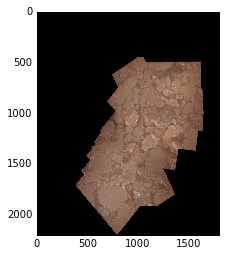

In [141]:
face_test = False
ice_test = True
addedge = True
reload(m)
#bpath = "/Volumes/johannah_external 1/thesis-work/201511_sea_state_DRI_Sikululiaq/uas_data/seastate_october_20/n2/image/"
#inpath = os.path.join(bpath, "flight_2")
#outpath = os.path.join(bpath, "flight_2_out")
do_clear = True
#lsize = (400, 200)
if ice_test:
    bpath = "/Users/jhansen/Desktop/"
    inpath = os.path.join(bpath, "test_in")
    outpath = os.path.join(bpath, "test_out")
    do_clear = True
    lsize = (600, 400)    
    
if face_test:
    inpath = 'jo_patch/'
    outpath = 'aout'
    do_clear = True
    lsize = (400, 200)
dm = doMosaic(inpath, outpath, 'jpg', do_clear=do_clear, limit=14, wsize=lsize, addedge=False)
dm.run_round(1)
a=cv2.imread(glob(outpath+'/*.png')[0])
plt.imshow(a)

In [66]:
#TODO develop image names in such a way that they are temporal even after adding names
# do scale filtering based on altitude
# keep track of which images are in base
# store kpts/desc if already searched
# warp the keypoint/descriptors too

In [8]:
def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    plt.tight_layout()

In [44]:
a = imread('dji_0029s.jpg')
a.shape
aa = deepcopy(a)

In [135]:
ab = cv2.imread('/Users/jhansen/Desktop/test_out/RUN001_MATCH000.png', cv2.IMREAD_UNCHANGED)
ab.shape

(931, 921, 4)

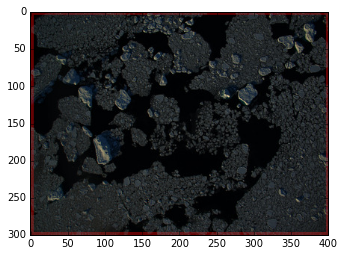

In [47]:
aa[:5,:,0] = 100
aa[a.shape[0]-4:,:,0] = 100
aa[:,:5,0] = 100
aa[:,a.shape[1]-4:,0] = 100
plt.imshow(aa)

In [10]:
p = Popen(cmd, stdin=PIPE, stdout=PIPE, stderr=PIPE)
output, err = p.communicate(b"input data that is passed to subprocess' s
rc = p.returncode

SyntaxError: EOL while scanning string literal (<ipython-input-10-8bfa2739f32c>, line 2)

cv::Stitcher is fairly slow. If your cameras definitely don't move relative to one another and the transformation is as simple as you say, you should be able to overlay the images onto a blank canvas simply by chaining homographies.

The following is somewhat mathematical - if this isn't clear I can write it up properly using LaTeX, but SO doesn't support pretty maths :)

You have a set of 4 cameras, from left to right, (C_1, C_2, C_3, C_4), giving a set of 4 images (I_1, I_2, I_3, I_4).

To transform from I_1 to I_2, you have a 3x3 transformation matrix, called a homography. We'll call this H_12. Similarly for I_2 to I_3 we have H_23 and for I_3 to I_4 you'll have H_34.

You can pre-calibrate these homographies in advance using the standard method (point matching between the overlapping cameras).

You'll need to create a blank matrix, to act as the canvas. You can guess the size of this (4*image_size would suffice) or you can take the top-right corner (call this P1_tr) and transform it by the three homographies, giving a new point at the top-right of the panorama, PP_tr (the following assumes that P1_tr has been converted to a matrix):

PP_tr = H_34 * H_23 * H_12 * P1_tr'
What this is doing, is taking P1_tr and transforming it first into camera 2, then from C_2 to C_3 and finally from C_3 to C_4

You'll need to create one of these for combining images 1 and 2, images 1,2 and 3 and finally images 1-4, I'll refer to them as V_12, V_123 and V_1234 respectively.

Use the following to warp the image onto the canvas:

cv::warpAffine(I_2, V_12, H_12, V_12.size( ));
Then do the same with the next images:

cv::warpAffine(I_3, V_123, H_23*H_12, V_123.size( ));
cv::warpAffine(I_4, V_1234, H_34*H_23*H_12, V_1234.size( ));
Now you have four canvases, all of which are the width of the 4 combined images, and with one of the images transformed into the relevant place on each.

All that remains is to merge the transformed images onto eachother. This is easily achieved using regions of interest.

Creating the ROI masks can be done in advance, before frame capture begins.

Start with a blank (zeros) image the same size as your canvases will be. Set the leftmost rectangle the size of I_1 to white. This is the mask for your first image. We'll call it M_1.

Next, to get the mask for the second transformed image, we do

cv::warpAffine(M_1, M_2, H_12, M_1.size( ));
cv::warpAffine(M_2, M_3, H_23*H_12, M_1.size( ));
cv::warpAffine(M_3, M_4, H_34*H_23*H_12, M_1.size( ));
To bring all the images together into one panorama, you do:

cv::Mat pano = zeros(M_1.size( ), CV_8UC3);
I_1.copyTo(pano, M_1);
V_12.copyTo(pano, M_2): 
V_123.copyTo(pano, M_3): 
V_1234.copyTo(pano, M_4): 
What you're doing here is copying the relevant area of each canvas onto the output image, pano - a fast operation.

You should be able to do all this on the GPU, substituting cv::gpu::Mat's for cv::Mats and cv::gpu::warpAffine for its non-GPU counterpart.

shareimprove this answer
edited Apr 1 '15 at 21:07
answered Apr 1 '15 at 20:54

n00dle
3,4631835


In [ ]:
#from skimage.feature.util import _mask_border_keypoints, DescriptorExtractor
class zernike(DescriptorExtractor):
    
    def __init__(self, descriptor_size=256, patch_size=49,
                  sigma=1, sample_seed=1, mask=None):
        self.descriptor_size = descriptor_size
        self.patch_size = patch_size
        self.sigma = sigma
        self.sample_seed = sample_seed

        self.descriptors = None
        self.mask = mask
    
    def extract(self, image, keypoints):
        patch_size = self.patch_size
        desc_size = self.descriptor_size
        random = np.random.RandomState()
        random.seed(self.sample_seed)
        samples = (patch_size / 5.0) * random.randn(desc_size * 8)
        samples = np.array(samples, dtype=np.int32)
        samples = samples[(samples < (patch_size // 2))
                          & (samples > - (patch_size - 2) // 2)]

        pos1 = samples[:desc_size * 2].reshape(desc_size, 2)
        pos2 = samples[desc_size * 2:desc_size * 4].reshape(desc_size, 2)
        
        pos1 = np.ascontiguousarray(pos1)
        pos2 = np.ascontiguousarray(pos2)
        self.mask = _mask_border_keypoints(image.shape, keypoints,
                                           patch_size // 2)
        keypoints = np.array(keypoints[self.mask, :], dtype=np.intp,
                             order='C', copy=False)
        self.descriptors = np.zeros((keypoints.shape[0], desc_size),
                                    dtype=bool, order='C')
        
        _zern_loop(image, self.descriptors.view(np.uint8), keypoints,
                    pos1, pos2)
        
def _zern_loop(image, descriptors, keypoints, pos0, pos1):
    for p in range(pos0.shape[0]):
        pr0 = pos0[p, 0]
        pc0 = pos0[p, 1]
        pr1 = pos1[p, 0]
        pc1 = pos1[p, 1]
        for k in range(keypoints.shape[0]):
            kr = keypoints[k, 0]
            kc = keypoints[k, 1]
            if image[kr + pr0, kc + pc0] < image[kr + pr1, kc + pc1]:
                descriptors[k, p] = True
                from mahotas.features import zernike_moments

br1 = zernike()
#keypoints = corner_peaks(corner_harris(img1), min_distance=5)
keypoints1 = corner_peaks(corner_harris(img1, method='eps', eps=.001, sigma=3), min_distance=5)
br1.extract(img1, keypoints1)
descriptors1 = br1.descriptors
keypoints1 = keypoints1[br1.mask]

br2 = zernike()
#keypoints1 = corner_peaks(corner_harris(img2), min_distance=5)
keypoints2 = corner_peaks(corner_harris(img2, method='eps', eps=.001, sigma=3), min_distance=5)
br2.extract(img2, keypoints)
descriptors2 = br2.descriptors
keypoints2 = keypoints2[br2.mask]